In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

from sklearn.svm import NuSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier # <- Here is our boy



In [4]:
# 0. load our PCA 4200 data_set
data_train = pd.read_csv('PCA_X_train_4200.csv')
y = data_train['label']
X = data_train.drop(['id', 'label'], axis=1)
data_test = pd.read_csv('PCA_X_test_4200.csv')
X_test = data_test.drop(['id'], axis=1)


In [7]:
#1. create a Log Reg class 
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class Log_Reg(BaseEstimator, RegressorMixin):
    def __init__(self,bs=5,epochs=100,lr=0.01):
        self.bs = bs
        self.epochs = epochs
        self.lr = lr
        self.w = 0
        self.b = 0
        self.losses = []

    #sigmoid function 
    def sigmoid(self,z):
        return 1.0/(1 + np.exp(-z))

    #loss function
    def loss(self,y, y_hat):
        loss = -np.mean(y*(np.log(y_hat)) - (1-y)*np.log(1-y_hat))
        return loss


    #gradient descent 
    def gradients(self,X, y, y_hat):
        m = X.shape[0]
        dw = (1/m)*np.dot(X.T, (y_hat - y))
        db = (1/m)*np.sum((y_hat - y)) 
        return dw, db

    def fit(self,X, y):
       
        if type(X) != np.array:
            X = np.array(X)
        if type(y) != np.array:
            y = np.array(y)
        
        X, y = check_X_y(X, y)
        m, n = X.shape
    
    # Initializing weights and bias to zeros.
        w = np.zeros((n,1))
        b = 0
        y = y.reshape(m,1)
        losses = []
        for epoch in range(self.epochs):
            for i in range((m-1)//self.bs + 1):
                
                # random batch of size bs.
                index = np.random.randint(0,(m-1)//self.bs + 1)
                # Defining batches. SGD.
                start_i = index*self.bs
                end_i = start_i + self.bs
                xb = X[start_i:end_i]
                yb = y[start_i:end_i]
                
                # Calculating hypothesis/prediction.
                y_hat = self.sigmoid(np.dot(xb, w) + b)
                
                # Getting the gradients of loss w.r.t parameters.
                dw, db = self.gradients(xb, yb, y_hat)
                
                # Updating the parameters.
                w -= self.lr*dw
                b -= self.lr*db
            
            # Calculating loss and appending it in the list.
            l = self.loss(y, self.sigmoid(np.dot(X, w) + b))
            losses.append(l)
            
        # returning weights, bias and losses(List).
        self.w = w
        self.b = b
        self.losses.append(losses)
        return w, b, losses

    #predict function 
    def predict(self,X):
        if type(X) != np.array:
            X = np.array(X)
        preds = self.sigmoid(np.dot(X, self.w) + self.b)
       
        pred_class = []
        pred_class = [1 if i > 0.5 else 0 for i in preds]
        return np.array(pred_class)
        

In [30]:
logr = Log_Reg(bs=10, epochs=10, lr=1)

In [31]:
logr.fit(X, y)

(array([[-1.49325533],
        [-0.27536144],
        [-1.73257007],
        ...,
        [ 0.29865216],
        [-0.09670665],
        [-0.01756879]]),
 -0.7640155776694623,
 [0.19853723581179555,
  0.154601548069137,
  0.12132409116113514,
  0.046896419397029494,
  -0.0026455807738090076,
  -0.12223423729178405,
  0.17743879151829262,
  -0.0007490003399042913,
  0.1631540700485447,
  -0.03735077785515014])

In [35]:

X_test = data_test.drop(['id'], axis=1)
y_pred = logr.predict(X_test)

#export convert numpy to dataframe
df = pd.DataFrame(y_pred, columns=['label'])
output = pd.concat([data_test['id'], df], axis=1)
#export df to csv
output.to_csv('069_test2.csv', index=False)


In [18]:
# 2. Create train and test set    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)

In [9]:
y_pred = logr.predict(X_test)
print("Accuracy of SVC:", metrics.accuracy_score(y_test, y_pred))
print("Precision of SVC:", metrics.precision_score(y_test, y_pred))
print("Recall of SVC:", metrics.recall_score(y_test, y_pred))
print("F1 score of SVC:", metrics.f1_score(y_test, y_pred))

array([0, 0, 1, ..., 1, 0, 0])

In [21]:
## Log_Reg hyperparameters tuning
from sklearn.model_selection import GridSearchCV
 
# defining parameter range
param_grid_rl = {'epochs': [5,10],
              'lr': [1, 0.1, 0.01, 0.001, 0.0001],
              'bs': [10, 100, 200, 500]}
 
grid_rl= GridSearchCV(Log_Reg(), param_grid_rl, refit = True, verbose = 3)
 
# fitting the model for grid search
grid_rl.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END ............bs=10, epochs=5, lr=1;, score=-0.165 total time=   6.1s
[CV 2/5] END ............bs=10, epochs=5, lr=1;, score=-0.176 total time=   4.4s
[CV 3/5] END ............bs=10, epochs=5, lr=1;, score=-0.257 total time=   7.3s
[CV 4/5] END ............bs=10, epochs=5, lr=1;, score=-0.206 total time=   4.3s
[CV 5/5] END ............bs=10, epochs=5, lr=1;, score=-0.199 total time=   4.4s
[CV 1/5] END ..........bs=10, epochs=5, lr=0.1;, score=-0.468 total time=   4.4s
[CV 2/5] END ..........bs=10, epochs=5, lr=0.1;, score=-0.529 total time=   5.4s
[CV 3/5] END ..........bs=10, epochs=5, lr=0.1;, score=-0.546 total time=   4.5s
[CV 4/5] END ..........bs=10, epochs=5, lr=0.1;, score=-0.578 total time=   4.8s
[CV 5/5] END ..........bs=10, epochs=5, lr=0.1;, score=-0.394 total time=   6.5s
[CV 1/5] END .........bs=10, epochs=5, lr=0.01;, score=-0.621 total time=   5.2s
[CV 2/5] END .........bs=10, epochs=5, lr=0.01;

GridSearchCV(estimator=Log_Reg(),
             param_grid={'bs': [10, 100, 200, 500], 'epochs': [5, 10],
                         'lr': [1, 0.1, 0.01, 0.001, 0.0001]},
             verbose=3)

In [28]:
## best parameters for Log_reg
grid_rl.best_params_
grid_rl.best_score_
print(grid_rl.best_estimator_)
pred = grid_rl.predict(X_test)


Log_Reg(bs=10, epochs=10, lr=1)


In [29]:
print("Accuracy of log:", metrics.accuracy_score(y_test, pred))

Accuracy of log: 0.7355251672970614


In [36]:
# NuSVC hyperparameters tuning
param_grid_nu = {'kernel': ['linear', 'sigmoid', 'poly'],
              'nu': [0.1, 0.3, 0.6, 0.7, 0.9],
              'gamma':['auto','scale']}
 
grid_nu= GridSearchCV(NuSVC(), param_grid_nu, refit = True, verbose = 3)
 
# fitting the model for grid search
grid_nu.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END .gamma=auto, kernel=linear, nu=0.1;, score=0.611 total time= 4.3min
[CV 2/5] END .gamma=auto, kernel=linear, nu=0.1;, score=0.613 total time= 5.5min
[CV 3/5] END .gamma=auto, kernel=linear, nu=0.1;, score=0.617 total time= 6.1min
[CV 4/5] END .gamma=auto, kernel=linear, nu=0.1;, score=0.613 total time= 4.3min
[CV 5/5] END .gamma=auto, kernel=linear, nu=0.1;, score=0.606 total time= 4.6min
[CV 1/5] END .gamma=auto, kernel=linear, nu=0.3;, score=0.662 total time= 4.1min
[CV 2/5] END .gamma=auto, kernel=linear, nu=0.3;, score=0.660 total time= 4.0min
[CV 3/5] END .gamma=auto, kernel=linear, nu=0.3;, score=0.649 total time= 3.3min
[CV 4/5] END .gamma=auto, kernel=linear, nu=0.3;, score=0.675 total time= 3.3min
[CV 5/5] END .gamma=auto, kernel=linear, nu=0.3;, score=0.664 total time= 3.3min
[CV 1/5] END .gamma=auto, kernel=linear, nu=0.6;, score=0.725 total time= 4.1min
[CV 2/5] END .gamma=auto, kernel=linear, nu=0.6

c:\Users\Pin Nean\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Pin Nean\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Pin Nean\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py", line 251, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "c:\Users\Pin Nean\AppData\Local\Programs\Pytho

GridSearchCV(estimator=NuSVC(),
             param_grid={'gamma': ['auto', 'scale'],
                         'kernel': ['linear', 'sigmoid', 'poly'],
                         'nu': [0.1, 0.3, 0.6, 0.7, 0.9]},
             verbose=3)

In [43]:
grid_nu.best_params_

{'gamma': 'auto', 'kernel': 'linear', 'nu': 0.6}

In [42]:
grid_nu.best_estimator_

NuSVC(gamma='auto', kernel='linear', nu=0.6)

In [38]:
# 3. Initializing classifiers
# Initializing SVC
classifier1 = SVC(C = 1, gamma = 1, kernel = "linear")


# Initialing Nu Support Vector classifier
classifier3 = NuSVC(gamma='auto', kernel = "linear", nu = 0.6)


classifier5 = Log_Reg(bs=10, epochs=500, lr=0.01)
# from sklearn.linear_model import LogisticRegression


In [27]:
# 4. Stacking Classifier                          #

from distutils.log import Log


sclf = StackingCVClassifier(classifiers = [classifier5, classifier3],
                            shuffle = False,
                            cv = 5,
                            meta_classifier = classifier1)

In [28]:
sclf.fit(X.iloc[:,0:4200],y)
# sclf.fit(X_train_o, y_train_o)

StackingCVClassifier(classifiers=[Log_Reg(bs=10, epochs=10, lr=1),
                                  NuSVC(gamma='auto', kernel='linear', nu=0.6)],
                     cv=5, meta_classifier=SVC(C=1, gamma=1, kernel='linear'),
                     shuffle=False)

In [39]:
sclf_rf100_lr500 = StackingCVClassifier(classifiers = [classifier5, classifier3],
                            shuffle = False,
                            cv = 5,
                            meta_classifier = classifier1)
sclf_rf100_lr500.fit(X.iloc[:,0:4200],y)

StackingCVClassifier(classifiers=[Log_Reg(bs=10, epochs=500),
                                  NuSVC(gamma='auto', kernel='linear', nu=0.6)],
                     cv=5, meta_classifier=SVC(C=1, gamma=1, kernel='linear'),
                     shuffle=False)

In [43]:
y_predict_rf100_lr500 = sclf_rf100_lr500.predict(X_test)

In [44]:
#export convert numpy to dataframe
df = pd.DataFrame(y_predict_rf100_lr500, columns=['label'])
output = pd.concat([data_test['id'], df], axis=1)
#export df to csv
output.to_csv('sclf_4200_meta-svc_base-lr500-nu.csv', index=False)

In [29]:
y_pred = sclf.predict(X_test.iloc[:,0:4200])

In [ ]:
#export convert numpy to dataframe
df = pd.DataFrame(y_pred, columns=['label'])
output = pd.concat([data_test['id'], df], axis=1)
#export df to csv
output.to_csv('sclf_4200_meta-svc_base-lr-nu.csv', index=False)

In [32]:

sclf_1 = StackingCVClassifier(classifiers = [classifier5, classifier3],
                            shuffle = False,
                            cv = 5,
                            meta_classifier = classifier1)

In [34]:
# sclf_1.fit(X_train.iloc[:,0:4200],y_train)
# sclf_1.fit(X_train.iloc[:,0:4200],y_train)

StackingCVClassifier(classifiers=[Log_Reg(bs=10, epochs=10, lr=1),
                                  NuSVC(gamma='auto', kernel='linear', nu=0.6)],
                     cv=5, meta_classifier=SVC(C=1, gamma=1, kernel='linear'),
                     shuffle=False)

In [35]:
y_pred_1 = sclf_1.predict(X_test.iloc[:,0:4200])

In [36]:
from sklearn import metrics

print("Accuracy :", metrics.accuracy_score(y_test, y_pred_1))
print("Precision :", metrics.precision_score(y_test, y_pred_1))
print("Recall :", metrics.recall_score(y_test, y_pred_1))
print("F1 score :", metrics.f1_score(y_test, y_pred_1))

Accuracy : 0.7340704102414897
Precision : 0.6965944272445821
Recall : 0.5212355212355212
F1 score : 0.5962897526501766


In [30]:
#export convert numpy to dataframe
df = pd.DataFrame(y_pred, columns=['label'])
output = pd.concat([data_test['id'], df], axis=1)
#export df to csv
output.to_csv('sclf_4200_meta-svc_base-lr-nu.csv', index=False)

In [13]:
###############################################################################
#                       7. Putting classifiers in a dictionary                #
###############################################################################
# Create list to store classifiers
classifiers = {"SVC": classifier1,
               "MLP": classifier2,
               "NuSVC": classifier3,
               "RF": classifier4,
               "Stack": sclf}

In [11]:
y_pred_sclf = sclf.predict(X_test)

c:\Users\Pin Nean\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- pca_2501
- pca_2502
- pca_2503
- pca_2504
- pca_2505
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 4200 features, but SVC is expecting 2500 features as input.

In [ ]:
y_pred_sclf

array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
#export convert numpy to dataframe
df = pd.DataFrame(y_pred_sclf, columns=['label'])
output = pd.concat([data_test['id'], df], axis=1)
#export df to csv
output.to_csv('sclf_2500.csv', index=False)

In [14]:
###############################################################################
#                               8. Train classifiers                          #
###############################################################################
# Train classifiers
for key in classifiers:
    # Get classifier
    classifier = classifiers[key]
    
    # Fit classifier
    classifier.fit(X_train, y_train)
        
    # Save fitted classifier
    classifiers[key] = classifier

c:\Users\Pin Nean\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [105]:
###############################################################################
#                              9. Making predictions                          #
###############################################################################
# Get results
results = pd.DataFrame()
for key in classifiers:
    # Make prediction on test set
    y_pred = classifiers[key].predict_proba(X_test)[:,1]
    
    # Save results in pandas dataframe object
    results[f"{key}"] = y_pred

# Add the test set to the results object
results["Target"] = y_test

c:\Users\Pin Nean\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


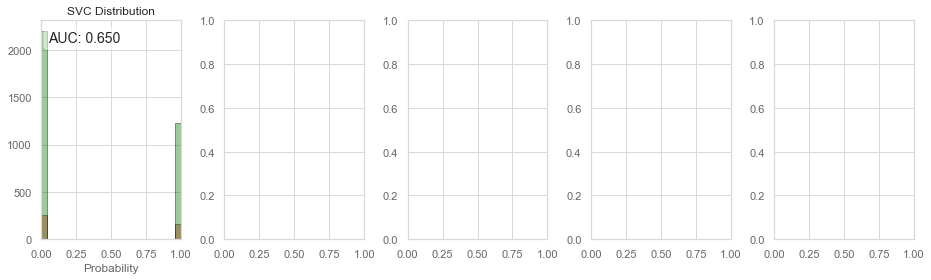

In [106]:
###############################################################################
#                              10. Visualzing results                         #
###############################################################################
# Probability Distributions Figure
# Set graph style
sns.set(font_scale = 1)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

# Plot
f, ax = plt.subplots(figsize=(13, 4), nrows=1, ncols = 5)

for key, counter in zip(classifiers, range(5)):
    # Get predictions
    y_pred = results[key]
    
    # Get AUC
    auc = metrics.roc_auc_score(y_test, y_pred)
    textstr = f"AUC: {auc:.3f}"

    # Plot false distribution
    false_pred = results[results["Target"] == 0]
    sns.distplot(false_pred[key], hist=True, kde=False, 
                 bins=int(25), color = 'red',
                 hist_kws={'edgecolor':'black'}, ax = ax[counter])
    
    # Plot true distribution
    true_pred = results[results["Target"] == 1]
    sns.distplot(results[key], hist=True, kde=False, 
                 bins=int(25), color = 'green',
                 hist_kws={'edgecolor':'black'}, ax = ax[counter])
    
    
    # These are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    
    # Place a text box in upper left in axes coords
    ax[counter].text(0.05, 0.95, textstr, transform=ax[counter].transAxes, fontsize=14,
                    verticalalignment = "top", bbox=props)
    
    # Set axis limits and labels
    ax[counter].set_title(f"{key} Distribution")
    ax[counter].set_xlim(0,1)
    ax[counter].set_xlabel("Probability")

# Tight layout
plt.tight_layout()

# Save Figure
plt.savefig("Probability Distribution for each Classifier.png", dpi = 1080)